# Using Deep Learning Models to do Time Series Forecasting

This tutorial introduces the use of deep learning foundation models and their applications to time series forecasting

**Duration:** ~10 minutes

## Learning objectives

By the end of this tutorial, you will be able to:
- Understand the terminology and applications of foundation deep learning models
- Choosing correct configuration parameters when initializing deep learning models
- Fine-tune a global forecaster for a time series dataset
- Understand zero-shot forecasting with deep learning models

## 1. Background

### Global Forecasting

Since the introduction of the transformer deep learning architecture, the applications of deep learning models has reached new heights, including time series forecasting. Typical time series forecasting involves training a separate model for each time series considered in the dataset. Global forecasting involves creating a single forecaster that simultaneously trains on multiple time series together at once. Since time series datasets are vectorized in nature, global forecasters can be efficiently trained to identify shared patterns between time series, improving accuracy and predictions when compared to traditional time series methods.

### Finetuning Pre-trained Models

Finetuning pre-trained models means starting with a model that has already learned general patterns from large, diverse datasets, and then adapting it to your specific data. This process is efficient and often leads to better performance, as the model benefits from both broad prior knowledge and specialized learning on your dataset. In time series forecasting, finetuning enables rapid adaptation to new domains or tasks with limited data, while retaining the strengths of the original foundation model.

In this tutorial, we will showcase fine-tuning a pretrained global forecaster to a new dataset, and perform zero-shotting (using a model to generate predictions without any new training) on a new dataset.

## 2. Model Finetuning with trained PatchTST Forecaster
This section demonstrates how to finetune a deep learning time series model `PatchTST` on your specific dataset. Finetuning allows the model to learn patterns unique to your data, potentially improving forecasting accuracy. In order to finetune this model on our US change dataset, we load a foundation model `namctin/patchtst_etth1_forecast` and tune a subset of weights based on the passed configuration

We will be using the Austrailian Electricity Demand Dataset for this portion of the dataset, which contains the half hourly electricity demand of 5 states in Australia: Victoria, New South Wales, Queensland, Tasmania and South Australia. It has roughly 230,000 rows starting in 2006. 

Credit to Benedikt's [tutorial](https://medium.com/@benedikt_heidrich/forecasting-using-foundation-models-and-sktime-4d5a09909742) for some of the code here!

In [ ]:
# Do imports
import pandas as pd

from sktime.datasets import load_forecastingdata

raw_data = load_forecastingdata("australian_electricity_demand_dataset")[0]
data = raw_data.set_index("series_name")

df = pd.DataFrame()

for i in range(len(data)):
    series = data.loc[f"T{i + 1}"]["series_value"]
    y = pd.DataFrame(
        series, index=pd.date_range("2006-01-01", periods=len(series), freq="30min")
    )
    # here we truncate the series to be of equal length
    y = y.iloc[:230736]
    y = y.resample("h").mean()
    y.columns = [f"T{i + 1}"]
    # only get dataframe of minimum length of series
    df = pd.concat([df, y], axis=1)

### How Deep Learning Models Work & PatchTST Forecaster Parameters
Deep learning models, such as transformers, learn patterns in time series data by processing sequences of values and identifying relationships over time. They use layers of interconnected neurons and attention mechanisms to capture complex dependencies, enabling accurate forecasting even for long and multivariate time series.

#### PatchTST Forecaster Parameters
PatchTST is a transformer-based model for time series forecasting. Its configuration is split into two main groups:
- **Model configuration parameters** (e.g., `context_length`, `prediction_length`, `num_attention_heads`) define the architecture and how the model processes data. These control the receptive field, forecast horizon, and complexity of the attention mechanism. There could be also model specific parameters that could exist for a model's configuration during initialization/training. For example: the `PatchTST` model uses `patch_length` and `patch_stride`.
- **Training arguments** (e.g., `learning_rate`, `num_train_epochs`, `per_device_train_batch_size`) control how the model is optimized during training. These affect how quickly and robustly the model learns from data.

**Parameter explanations:**
- **learning_rate** (training arg): Controls how much the model weights are updated during training. Lower values mean slower, more stable learning; higher values can speed up training but risk instability.
- **num_train_epochs** (training arg): The number of times the model sees the entire training dataset. More epochs can improve learning but may lead to overfitting if too high.
- **per_device_train_batch_size** (training arg): Number of samples processed before updating model weights. Larger batch sizes can speed up training and stabilize gradients, but require more memory.
- **context_length** (model config): Number of past time steps the model uses to make predictions. Longer context can help capture more temporal patterns but increases computational cost.
- **prediction_length** (model config): Number of future time steps the model predicts in one go. Larger values allow for longer forecasts but may reduce accuracy if too large.
- **num_attention_heads** (model config): Number of parallel attention mechanisms in the transformer. More heads can help the model learn complex relationships but increase model size and computation.
- **patch_length** (PatchTST model config): Number of which each input univariate time series will be divided by to split the series into patches.
- **patch_stride** (PatchTST model config): The non overlapping region between two consecutive patches. 

In summary, model configuration parameters shape the forecaster's architecture and its ability to learn from data, while training arguments determine how the learning process is carried out.

In [2]:
from sktime.forecasting.patch_tst import PatchTSTForecaster

forecaster = PatchTSTForecaster(
    model_path="namctin/patchtst_etth1_forecast",
    config={
        "patch_length": 8,
        "context_length": 96,
        "patch_stride": 8,
        "num_attention_heads": 4,
        "head_dropout": 0.3,
        "prediction_length": 96,
    },
    fit_strategy="minimal",
    training_args={
        "output_dir": "test_output",
        "overwrite_output_dir": True,
        "learning_rate": 1e-4,
        "num_train_epochs": 10,
        "per_device_train_batch_size": 64,
        "logging_steps": 500,
    },
)  # doctest: +SKIP
forecaster.fit(df[:-192], fh=range(1, 96))  # doctest: +SKIP
y_pred = forecaster.predict(y=df[-192:-96])  # doctest: +SKIP

d:\Anaconda\envs\sktime_\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of PatchTSTForPrediction were not initialized from the model checkpoint at namctin/patchtst_etth1_forecast and are newly initialized because the shapes did not match:
- model.encoder.embedder.input_embedding.weight: found shape torch.Size([128, 12]) in the checkpoint and torch.Size([128, 8]) in the model instantiated
- model.encoder.positional_encoder.position_enc: found shape torch.Size([43, 128]) in the checkpoint and torch.Size([13, 128]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of PatchTSTForPrediction were not initialized from the model checkpoint at namctin/patchtst_etth1_forecast and are newly initialized because th

Step,Training Loss
500,358685.792000
1000,267977.536000
1500,254251.936000
2000,248908.272000
2500,246810.736000
3000,244113.056000
3500,242565.712000
4000,241163.552000
4500,239274.080000
5000,239122.384000


Here, we showcase how many weights of the original model are being fine-tuned. We currently have 0.4% trainable parameters that we finetune on this specific dataset

In [3]:
model = forecaster.model

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters (weights and biases): {total_params}")

# Count parameters with requires_grad=True
trainable_params_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {trainable_params_count}")

Total number of parameters (weights and biases): 610144
Total number of trainable parameters: 2688


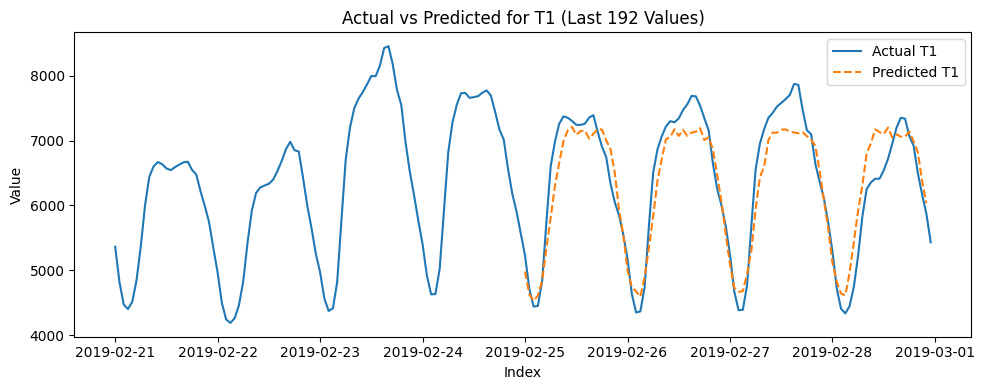

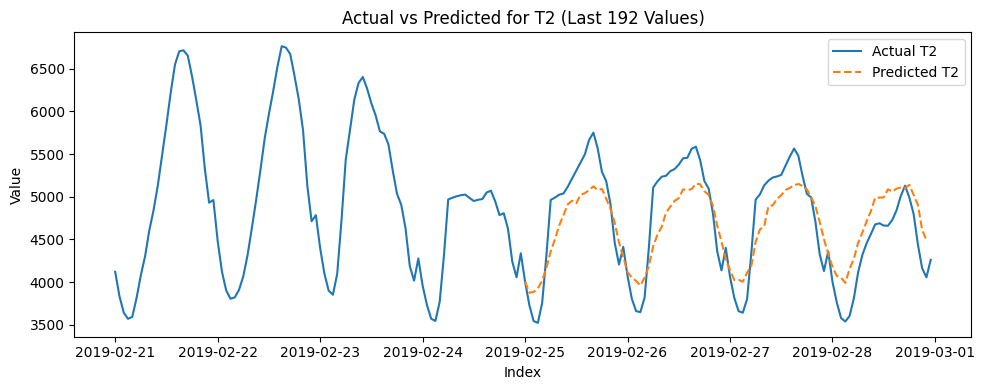

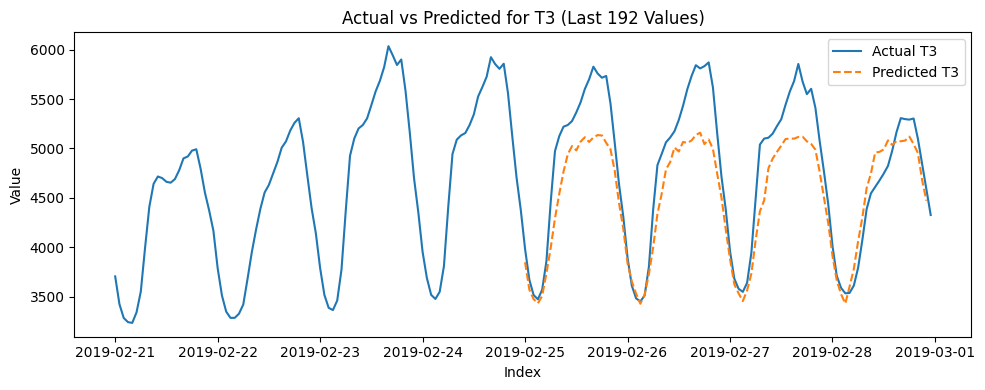

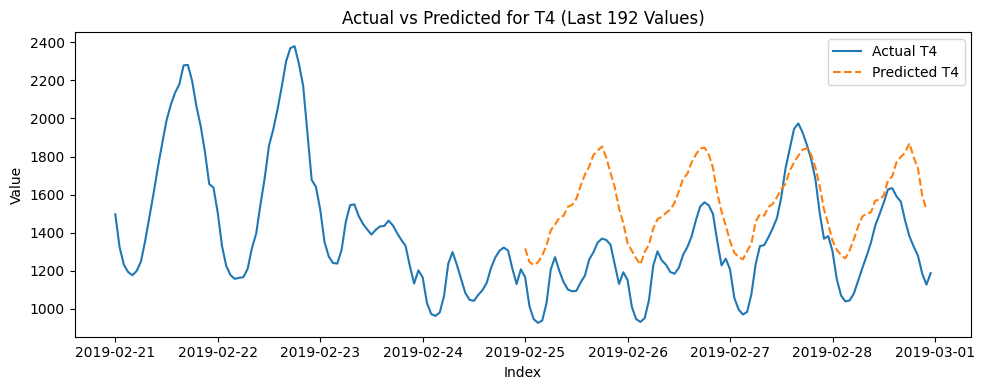

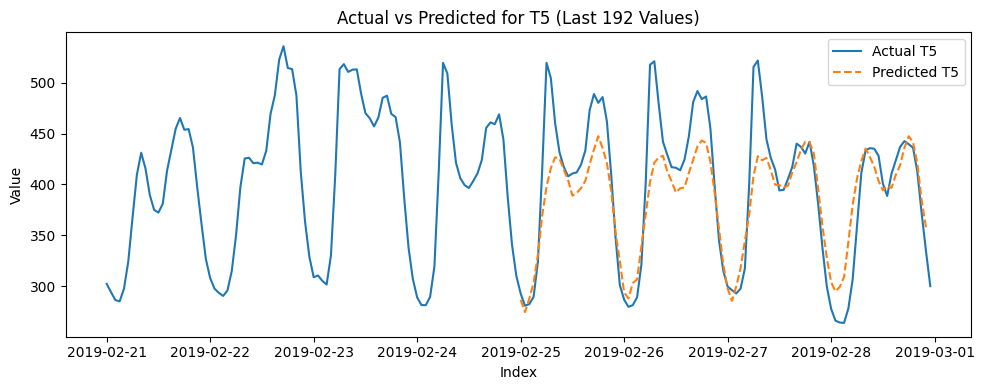

In [4]:
import matplotlib.pyplot as plt

# Plot predictions for T1 to T5 (last 192 values only), each in a separate plot
for i in range(1, 6):
    col = f"T{i}"
    if col in df.columns and col in y_pred.columns:
        plt.figure(figsize=(10, 4))
        plt.plot(
            df.index[-192:], df[col].iloc[-192:], label=f"Actual {col}", linestyle="-"
        )
        plt.plot(
            y_pred.index[-192:],
            y_pred[col].iloc[-192:],
            label=f"Predicted {col}",
            linestyle="--",
        )
        plt.xlabel("Index")
        plt.ylabel("Value")
        plt.title(f"Actual vs Predicted for {col} (Last 192 Values)")
        plt.legend()
        plt.tight_layout()
        plt.show()

## 3. Zero-Shot Forecasting with MOIRAI Forecaster
This section demonstrates zero-shot forecasting using the MOIRAI forecaster. Zero-shot models leverage pre-trained deep learning foundation models to make predictions on new time series data without additional training or finetuning. This approach is useful when you want to quickly apply a powerful model to a new dataset, relying on the generalization capabilities of the foundation model.

### Import Libraries and Load Data
Imports the necessary libraries and loads the time series dataset for forecasting. The US Change dataset contains percentage changes in quarterly personal consumption expenditure, personal disposable income, production, savings, and the unemployment rate for the US from 1960 to 2016.

This is a multivariate dataset over a period between 1960 to 2016, and contains roughly 187 rows.

In [5]:
import pandas as pd

from sktime.datasets.forecasting import USChange

y, X = USChange().load("y", "X")

In [6]:
y.head()

,Consumption,Income,Production,Savings,Unemployment
0,0.615986,0.972261,-2.452700,4.810312,0.9
1,0.460376,1.169085,-0.551525,7.287992,0.5
2,0.876791,1.553271,-0.358708,7.289013,0.5
3,-0.274245,-0.255272,-2.185455,0.985230,0.7
4,1.897371,1.987154,1.909734,3.657771,-0.1


### Visualizing Time Series and Predictions
This section creates plots to visualize the original time series data and compare actual values with model predictions. Visualization helps to assess model performance and understand time series patterns.

In [ ]:
import matplotlib.pyplot as plt

# Plot each column of y in its own chart (subplot)
if isinstance(y, pd.DataFrame):
    num_cols = len(y.columns)
    fig, axes = plt.subplots(num_cols, 1, figsize=(10, 4 * num_cols), sharex=True)
    if num_cols == 1:
        axes = [axes]
    for i, col in enumerate(y.columns):
        axes[i].plot(y.index, y[col])
        axes[i].set_ylabel(col)
        axes[i].set_title(f"y values for column: {col}")
    axes[-1].set_xlabel("Index")
    plt.tight_layout()
    plt.show()
else:
    # If y is a Series, plot directly
    y.plot(figsize=(10, 6), title="y values over index range")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.show()

### Train/Test Split
Here we split the time series data into training and testing sets, using the first 70% for training and the remaining 30% to compare predictions vs actual values.

In [8]:
# Split y into train and test sets (first 70% train, last 30% test)
split_idx = int(len(y) * 0.7)
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]
y_ = y_test[:28]
print(f"Train shape: {y_train.shape}")
print(f"Test shape: {y_test.shape}")

forecast_length = len(y_test) // 2
forecast_length

Train shape: (130, 5)
Test shape: (57, 5)


28

We will refrain from touching any of the model configurations for the `MOIRAIForecaster`, and opt to just load in the pre-trained model using the `checkpoint_path` parameter

In [9]:
from sktime.forecasting.moirai_forecaster import MOIRAIForecaster

morai_forecaster = MOIRAIForecaster(checkpoint_path="Salesforce/moirai-1.0-R-small")
morai_forecaster.fit(y=y_train, fh=range(1, 29))

d:\Anaconda\envs\sktime_\Lib\site-packages\gluonts\json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


MOIRAIForecaster(checkpoint_path='Salesforce/moirai-1.0-R-small')

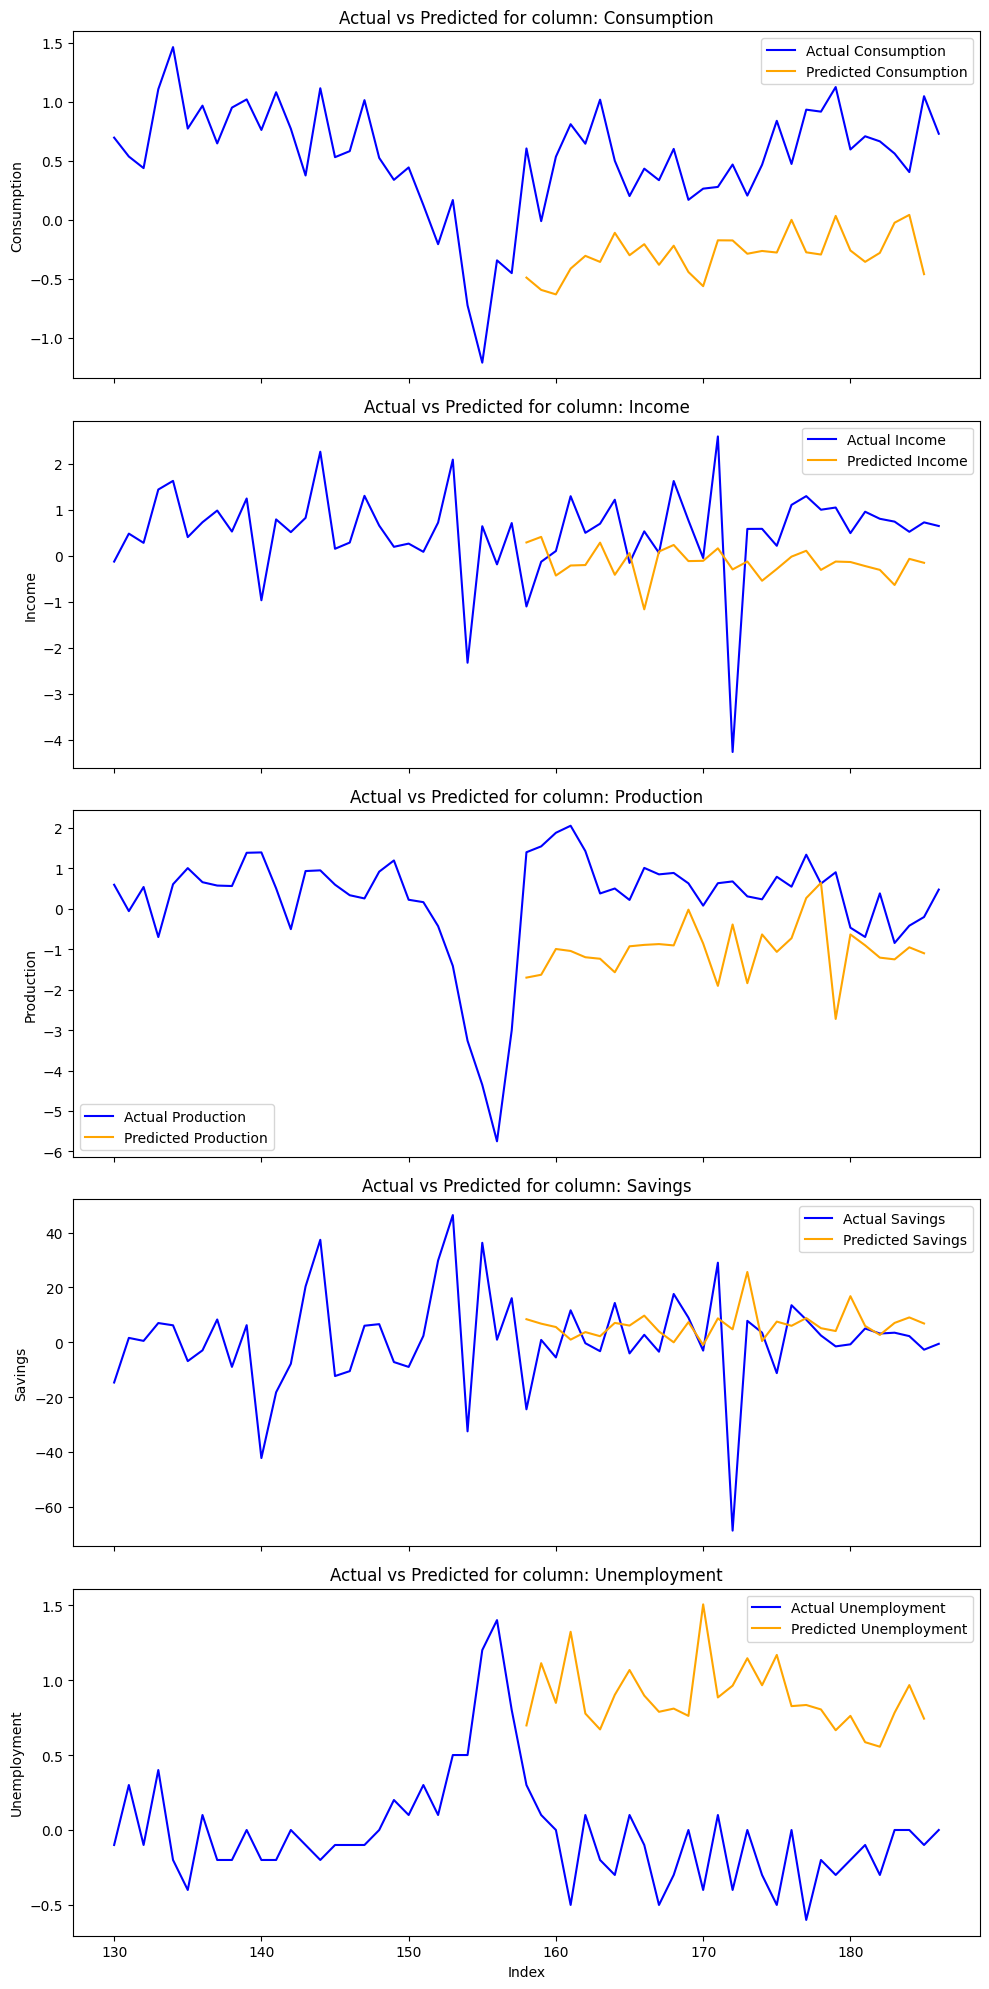

In [10]:
# Plot the original test values and overlay predictions from morai_forecaster
y_pred = morai_forecaster.predict(y=y_test[:28])

import matplotlib.pyplot as plt

if isinstance(y_test, pd.DataFrame):
    num_cols = len(y_test.columns)
    fig, axes = plt.subplots(num_cols, 1, figsize=(10, 4 * num_cols), sharex=True)
    if num_cols == 1:
        axes = [axes]
    for i, col in enumerate(y_test.columns):
        axes[i].plot(y_test.index, y_test[col], label=f"Actual {col}", color="blue")
        if col in y_pred.columns:
            axes[i].plot(
                y_pred.index, y_pred[col], label=f"Predicted {col}", color="orange"
            )
        axes[i].set_ylabel(col)
        axes[i].set_title(f"Actual vs Predicted for column: {col}")
        axes[i].legend()
    axes[-1].set_xlabel("Index")
    plt.tight_layout()
    plt.show()
else:
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test, label="Actual", color="blue")
    plt.plot(y_pred.index, y_pred, label="Predicted", color="orange")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.title("Actual vs Predicted")
    plt.legend()
    plt.show()